In [14]:
def read_data_and_classes(data_dir):
    datasets = {}
    class_set = set()  # Set to store unique classes
    splits = ['train', 'test', 'val']
    for split in splits:
        image_dir = os.path.join(data_dir, 'images', split)
        label_dir = os.path.join(data_dir, 'labels', split)
        images = []
        labels = []
        
        for filename in os.listdir(image_dir):
            if filename.endswith(('.png', '.jpg')):
                image_path = os.path.join(image_dir, filename)
                label_filename = os.path.splitext(filename)[0] + '.txt'
                label_path = os.path.join(label_dir, label_filename)
                
                image = cv2.imread(image_path)
                image = cv2.resize(image, (224, 224))
                image = image / 255.0
                
                with open(label_path, 'r') as file:
                    label_data = file.read().strip().split()
                    label = int(label_data[0])  # Assuming first item is the class
                    class_set.add(label)  # Add class to set
                
                images.append(image)
                labels.append(label)
        
        datasets[split] = (np.array(images), np.array(labels))
    
    return datasets, sorted(class_set)  # Return datasets and sorted list of unique classes

data_dir = '/home/mahin/Downloads/Capstone/Capstone/data'
datasets, classes = read_data_and_classes(data_dir)

print("Unique classes in the dataset:", classes)


Unique classes in the dataset: [0, 1, 2, 3, 4]


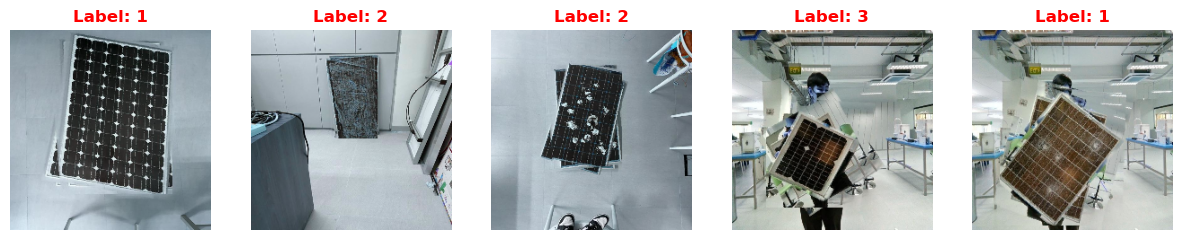

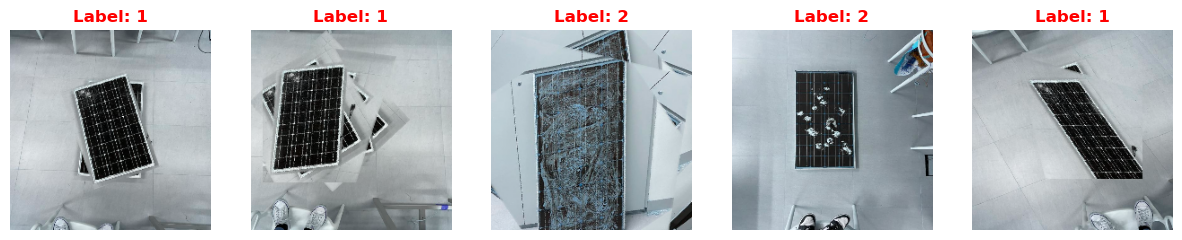

In [36]:
import matplotlib.pyplot as plt

def show_images_with_labels(images, labels, num_images=5):
    # Choose random indices to display images
    indices = np.random.choice(np.arange(len(images)), num_images, replace=False)
    
    plt.figure(figsize=(15, 5))
    for i, index in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[index])
        # Set title with red color and bold font
        plt.title(f'Label: {labels[index]}', color='red', fontweight='bold')
        plt.axis('off')
    plt.show()

# Example usage:
show_images_with_labels(datasets['train'][0], datasets['train'][1], num_images=5)
show_images_with_labels(datasets['train'][0], datasets['train'][1], num_images=5)



In [32]:
import cv2


image = cv2.rectangle(datasets['train'][1],(datasets['train'][1][0],datasets['train'][1][1]),(datasets['train'][1][2],datasets['train'][1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


NameError: name 'dataset' is not defined

TypeError: cannot unpack non-iterable numpy.int64 object

<Figure size 2000x1000 with 0 Axes>

In [18]:

import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the paths to the images and CSV files
base_dir = 'retinanet'
train_csv_path = os.path.join(base_dir, 'train', '_annotations.csv')
test_csv_path = os.path.join(base_dir, 'test', '_annotations.csv')
val_csv_path = os.path.join(base_dir, 'validation', '_annotations.csv')

# Function to read the dataset from CSV files
def load_dataset(csv_path, images_path):
    df = pd.read_csv(csv_path)
    images = []
    labels = []
    
    for index, row in df.iterrows():
        # Build the complete image path
        image_filename = row['filename']
        image_path = os.path.join(images_path, image_filename)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
            image = cv2.resize(image, (224, 224))  # Resize to the desired input size for VGG16
            image = image / 255.0  # Normalize the image
            images.append(image)
            
            # Assuming the class label is in a column named 'class'
            labels.append(row['class'])
    
    return np.array(images), np.array(labels)

# Load the datasets
train_images, train_labels = load_dataset(train_csv_path, os.path.join(base_dir, 'train'))
test_images, test_labels = load_dataset(test_csv_path, os.path.join(base_dir, 'test'))
val_images, val_labels = load_dataset(val_csv_path, os.path.join(base_dir, 'validation'))

# Convert labels to one-hot encoding
num_classes = len(set(train_labels))  # Update this if needed
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes)

# Set up ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerators for the train, validation, and test sets
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow(val_images, val_labels, batch_size=32)
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

# Now, you can use these generators to train a model using VGG16 architecture or any other model.


FileNotFoundError: [Errno 2] No such file or directory: 'retinanet/train/_annotations.csv'

In [49]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Function to read data and classes
def read_data_and_classes(data_dir):
    datasets = {}
    class_set = set()  # Set to store unique classes
    splits = ['train', 'test', 'val']
    for split in splits:
        image_dir = os.path.join(data_dir, 'images', split)
        label_dir = os.path.join(data_dir, 'labels', split)
        images = []
        labels = []
        
        for filename in os.listdir(image_dir):
            if filename.endswith(('.png', '.jpg')):
                image_path = os.path.join(image_dir, filename)
                label_filename = os.path.splitext(filename)[0] + '.txt'
                label_path = os.path.join(label_dir, label_filename)
                
                image = cv2.imread(image_path)
                image = cv2.resize(image, (224, 224))
                
                
                with open(label_path, 'r') as file:
                    label_data = file.read().strip().split()
                    label = int(label_data[0])  # Assuming first item is the class
                    class_set.add(label)  # Add class to set
                
                images.append(image)
                labels.append(label)
        
        datasets[split] = (np.array(images), np.array(labels))
    
    return datasets, sorted(class_set)  # Return datasets and sorted list of unique classes

input_shape = (224, 224, 3)

# Load VGG16 model and add custom classification head
def load_vgg16_model(num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='softmax')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Read data
data_dir = '/home/mahin/Downloads/Capstone/Capstone/data'
datasets, classes = read_data_and_classes(data_dir)

# Split data into train, test, and validation sets
train_data = {'train': datasets['train']}
val_data = {'val': datasets['val']}
test_data = {'test': datasets['test']}

# Data preprocessing
batch_size = 16
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
).flow(train_data['train'][0], train_data['train'][1], batch_size=batch_size, shuffle=True)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
).flow(
    val_data['val'][0], val_data['val'][1], batch_size=batch_size, shuffle=False)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
).flow(test_data['test'][0], test_data['test'][1], batch_size=batch_size, shuffle=False)

# Load VGG16 model
num_classes = len(classes)
model = load_vgg16_model(num_classes)
learning_rate = 0.01

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=10, validation_data=val_generator)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 861ms/step - accuracy: 0.3813 - loss: 1.4374 - val_accuracy: 0.1585 - val_loss: 1.4171
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 861ms/step - accuracy: 0.3766 - loss: 1.2659 - val_accuracy: 0.1585 - val_loss: 1.4308
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 873ms/step - accuracy: 0.3759 - loss: 1.2482 - val_accuracy: 0.1585 - val_loss: 1.4614
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 862ms/step - accuracy: 0.3919 - loss: 1.2179 - val_accuracy: 0.1585 - val_loss: 1.4538
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 864ms/step - accuracy: 0.3735 - loss: 1.2713 - val_accuracy: 0.1585 - val_loss: 1.4578
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 881ms/step - accuracy: 0.3981 - loss: 1.2426 - val_accuracy: 0.1585 - val_loss: 1.4480
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 860ms/step - accuracy: 0.3686 - loss: 1.2691 - val_accuracy: 0.1585 - val_loss: 1.4750
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 861ms/step - accuracy: 0.3898 - loss: 1.2425 - val_accu

In [61]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Base directory of the VOC dataset
base_dir = '/home/mahin/Downloads/Solar Panel Fault Detection Pascal VOC XML'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'valid')

# Function to parse the XML file and get the annotation data
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        bndbox = (int(xmlbox.find('xmin').text),
                  int(xmlbox.find('ymin').text),
                  int(xmlbox.find('xmax').text),
                  int(xmlbox.find('ymax').text))
        boxes.append((bndbox, class_name))
    return boxes


# Function to load dataset (images and labels)
def load_dataset(directory):
    images = []
    labels = []
    for img_filename in os.listdir(directory):
        if img_filename.endswith('.jpg'):
            img_path = os.path.join(directory, img_filename)
            annotation_path = img_path.replace('.jpg', '.xml')
            boxes = parse_annotation(annotation_path)

            image = cv2.imread(img_path)
            image = cv2.resize(image, (224, 224))
            images.append(image)

            # Assuming single object classification
            labels.append(boxes[0][1])  # Taking the first object's class label in the image
            
    return np.array(images), labels

# Load all datasets
train_images, train_labels = load_dataset(train_dir)
test_images, test_labels = load_dataset(test_dir)
val_images, val_labels = load_dataset(val_dir)

# Convert labels to numerical values
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)
val_labels = label_encoder.transform(val_labels)

# Convert to one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
val_labels = to_categorical(val_labels)

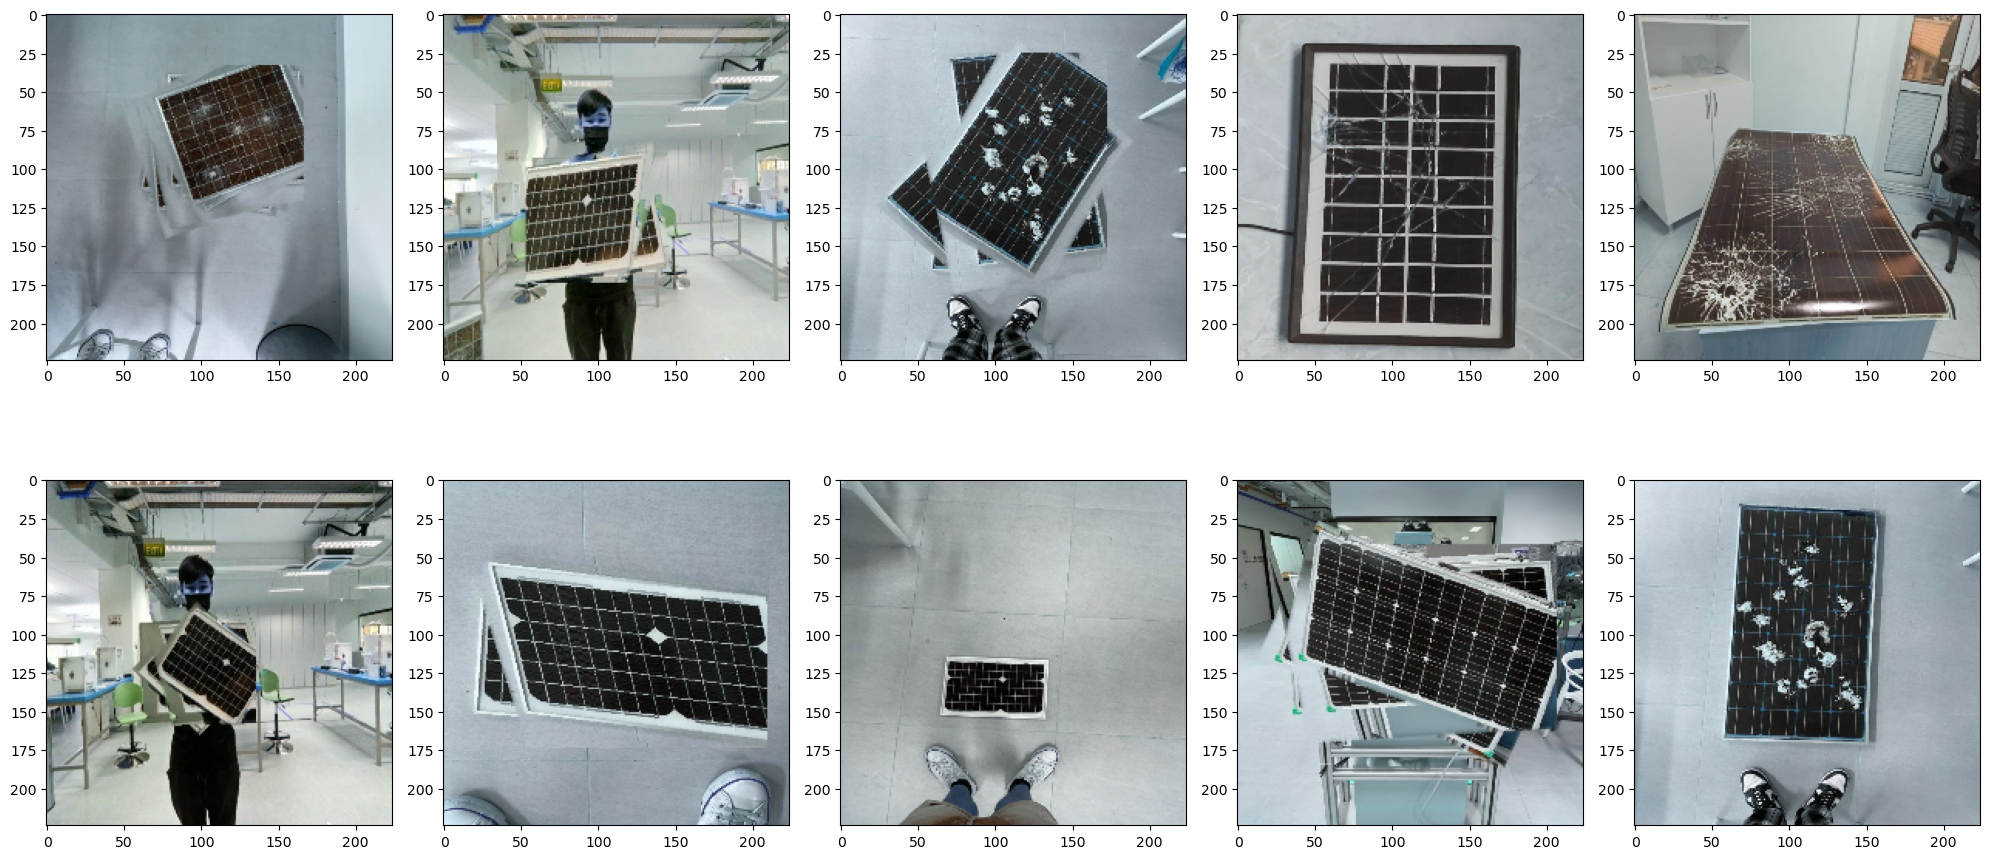

In [68]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Make sure you've run the dataset loading code before this

# Select 10 random indices
sample_indices = random.sample(range(len(train_images)), 10)

# Set up the matplotlib figure and axes
plt.figure(figsize=(20, 10))

for i, index in enumerate(sample_indices):
    # Load the image
    image = train_images[index]
    # Load the annotations
    annotations = train_labels[index]  # Assuming annotations are in the format (xmin, ymin, xmax, ymax, class_name)

    # Add subplot
    plt.subplot(2, 5, i+1)
    plt.imshow(image)

    

plt.tight_layout()
plt.show()


In [67]:

from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Add new custom layers on top of VGG16
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(train_labels.shape[1], activation='softmax')(x)  # train_labels.shape[1] gives the number of classes

# Define the new model
model = Model(inputs=base_model.input, outputs=output_layer)

learning_rate = 0.0001

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Assuming that your data is already loaded and preprocessed
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)


# Fit the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}, test accuracy: {test_accuracy}')

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 608ms/step - accuracy: 0.5627 - loss: 1.0527 - val_accuracy: 0.8537 - val_loss: 0.5556
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 602ms/step - accuracy: 0.8819 - loss: 0.4012 - val_accuracy: 0.9146 - val_loss: 0.4080
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 605ms/step - accuracy: 0.9395 - loss: 0.2466 - val_accuracy: 0.9024 - val_loss: 0.2687
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 610ms/step - accuracy: 0.9591 - loss: 0.1940 - val_accuracy: 0.9390 - val_loss: 0.1962
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 605ms/step - accuracy: 0.9603 - loss: 0.1693 - val_accuracy: 0.9512 - val_loss: 0.1675
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 606ms/step - accuracy: 0.9709 - loss: 0.1214 - val_accuracy: 0.9390 - val_loss: 0.2101
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 611ms/step - accuracy: 0.9368 - loss: 0.1664 - val_accuracy: 0.9390 - val_loss: 0.1852
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 605ms/step - accuracy: 0.9587 - loss: 0.1372 - val_accu